# Lab 06 - Uncertainty Quantification

## Tasks

- Train different machine learning algorithms on noisy data
- Predict the uncertainty from the trained model

## Set up environment

In [1]:
%reset -f
!pip install botorch
!pip install cheetah-accelerator
!pip install blitz-bayesian-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm # For progress bar

# Gaussian process
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize


# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Create training data

We start by generating noisy data from a model of beam propagating through a single quad magnet (characterized by a magnetic strength `K1`). In order to simulate fluctuations in beam parameters and noise in the beam size measurement, we add noise in the model.

In [3]:
from cheetah.particles import ParameterBeam
from cheetah.accelerator import Drift, Quadrupole, Segment

incoming_beam = ParameterBeam.from_twiss(
    beta_x=torch.tensor(5.0),
    alpha_x=torch.tensor(0.0),
    emittance_x=torch.tensor(1e-8)
)

beamline = Segment(
    [
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q1",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0))
    ]
)

def calculate_x_beamsize(K, add_noise=False):
    # set beamline parameters
    beamline.Q1.k1 = K

    # track the beam
    final_beam = beamline.track(incoming_beam)

    # noise
    if add_noise:
        noise = torch.randn_like(K) * 1e-1
    else:
        noise = 0.0

    # return the beam size in x (in mm)
    return final_beam.sigma_x * 1e3 + noise

In [4]:
# Generate 400 samples for K1 varying between -300 and 300
n_samples = 400
bounds = torch.tensor([-30.0, 30.0])
train_x = torch.rand(n_samples) * (bounds[1] - bounds[0]) + bounds[0]
train_x = train_x.reshape(-1,1)
train_y = torch.cat([calculate_x_beamsize(train_x, add_noise=True)]).detach()

Text(0, 0.5, 'Beam size')

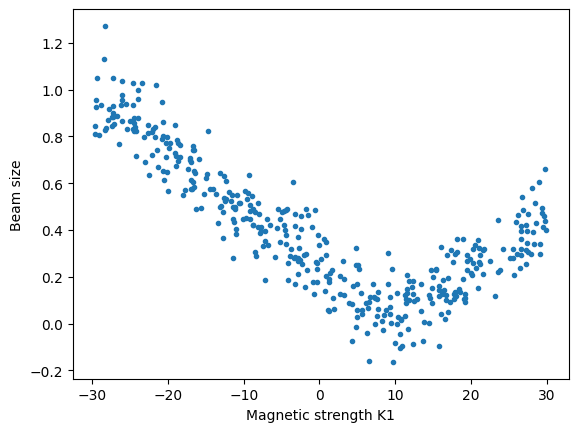

In [5]:
plt.plot(train_x, train_y, '.' )
plt.xlabel('Magnetic strength K1')
plt.ylabel('Beam size')

# Gaussian process

Here we fit a Gaussian process to the data, we draw a few samples from the GP and plot them, along with the uncertainty.

In [7]:
# Define a Gaussian Process model with Matern(5/2) kernel and Gaussian likelihood
gp = SingleTaskGP(
    train_x.double(), train_y.double(),
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)

# Train model hyperparameters by minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Text(0, 0.5, 'Normalized beam size')

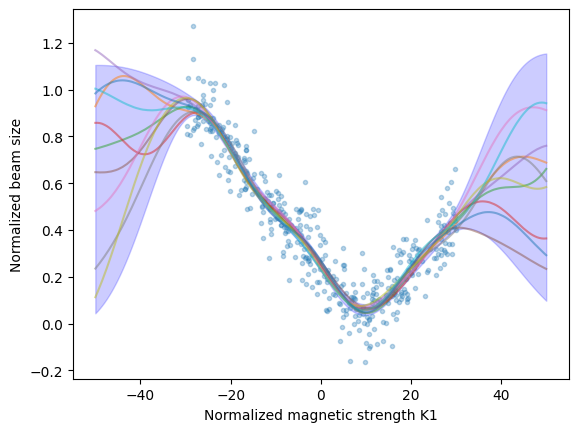

In [8]:
# Plot the original training data
plt.plot(train_x, train_y, '.', alpha=0.3)

# Draw samples of the GP, and plot them over the interval -0.5, 1.5
x = torch.linspace(-50.0, 50.0, 200).reshape(-1,1)
p = gp.posterior(x, observation_noise=False)

for _ in range(10):
    sample, = p.rsample()
    plt.plot( x.flatten(), sample.detach().numpy().flatten(), alpha=0.5 )

# Plot the analytical uncertainty
m = p.mean
l,u = p.mvn.confidence_region()
plt.fill_between( x.flatten(), l.detach().numpy(), u.detach().numpy(), color='b', alpha=0.2)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

> ### **Task:**
> Does the uncertainty behave as expected? In which way? Does the predicted uncertainty capture the aleatoric part or only the epistemic part? Copy the above code below, and change `observation_noise` from `False` to `True`. Does it now capture the aleatoric part or only the epistemic part?

> **Your answer here** It does behave as expected in the sense that the uncertainty in the GP mean is low, due to the high density of sampled points. So I guess this would refer to the epistemic uncertainty. As for the aleatoric, noisy part, only when we set the observation noise to True we see the GP uncerntainty reflecting the measurement fluctuations.

Text(0, 0.5, 'Normalized beam size')

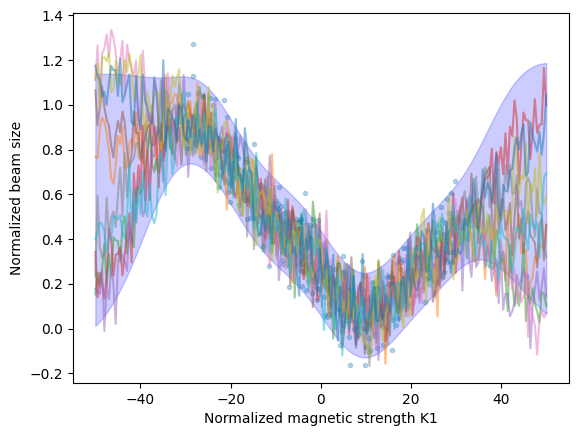

In [9]:
# Your code here: Copy the above code below, and change`observation_noise` from `False` to `True`.
# Define a Gaussian Process model with Matern(5/2) kernel and Gaussian likelihood

# Plot the original training data
plt.plot(train_x, train_y, '.', alpha=0.3)

# Draw samples of the GP, and plot them over the interval -0.5, 1.5
x = torch.linspace(-50.0, 50.0, 200).reshape(-1,1)
p = gp.posterior(x, observation_noise=True)

for _ in range(10):
    sample, = p.rsample()
    plt.plot( x.flatten(), sample.detach().numpy().flatten(), alpha=0.5 )

# Plot the analytical uncertainty
m = p.mean
l,u = p.mvn.confidence_region()
plt.fill_between( x.flatten(), l.detach().numpy(), u.detach().numpy(), color='b', alpha=0.2)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

> **Your answer here** (Does it now capture the aleatoric part or only the epistemic part?)

Not it captures both the epsitemic and aleatoric.

# Ensemble of neural networks

We will now train an **ensemble** of neural networks on the same data.

> ### **Task:**
> Implement a neural network with 2 hidden layers of 10 neurons each.
> Train 10 randomly initialized models on the same data. Store the trained models in a list.

In [11]:
# normalize training data
normed_train_x = ((train_x - train_x.min()) / (train_x.max() - train_x.min())).float()
normed_train_y = ((train_y - train_y.min()) / (train_y.max() - train_y.min())).float()

In [13]:
normed_train_y.shape

torch.Size([400, 1])

In [85]:
class NNModel(nn.Module):
    """
    Define fully-connected neural network with 2 hidden layers
    """
    def __init__(self):
        super(NNModel, self).__init__()

        hidden_size = 10  # Number of neurons in hidden layers

        # Define layers
        self.linear1 = nn.Linear(1, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, 1)

        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)

        return x

In [57]:
def generate_and_train_model( epochs=100 ):
    """
    Train a neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object
    """
    # Your code here: implement creation and training of one neural network model

    model = NNModel()
    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    for epoch in range(epochs):
        #iterate through data batches
        output = model(normed_train_x)
        loss = F.mse_loss(output, normed_train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch:003d} \t Loss: {loss.item():.3f}")
    print("")

    return model


In [58]:
# Train 10 different neural network on the same data
ensemble_models = [ generate_and_train_model() for _ in range(10) ]

Epoch: 000 	 Loss: 0.093
Epoch: 001 	 Loss: 0.034
Epoch: 002 	 Loss: 0.037
Epoch: 003 	 Loss: 0.045
Epoch: 004 	 Loss: 0.038
Epoch: 005 	 Loss: 0.028
Epoch: 006 	 Loss: 0.022
Epoch: 007 	 Loss: 0.021
Epoch: 008 	 Loss: 0.022
Epoch: 009 	 Loss: 0.023
Epoch: 010 	 Loss: 0.022
Epoch: 011 	 Loss: 0.019
Epoch: 012 	 Loss: 0.015
Epoch: 013 	 Loss: 0.012
Epoch: 014 	 Loss: 0.010
Epoch: 015 	 Loss: 0.010
Epoch: 016 	 Loss: 0.011
Epoch: 017 	 Loss: 0.011
Epoch: 018 	 Loss: 0.010
Epoch: 019 	 Loss: 0.008
Epoch: 020 	 Loss: 0.007
Epoch: 021 	 Loss: 0.007
Epoch: 022 	 Loss: 0.008
Epoch: 023 	 Loss: 0.008
Epoch: 024 	 Loss: 0.008
Epoch: 025 	 Loss: 0.008
Epoch: 026 	 Loss: 0.007
Epoch: 027 	 Loss: 0.007
Epoch: 028 	 Loss: 0.007
Epoch: 029 	 Loss: 0.007
Epoch: 030 	 Loss: 0.007
Epoch: 031 	 Loss: 0.007
Epoch: 032 	 Loss: 0.006
Epoch: 033 	 Loss: 0.006
Epoch: 034 	 Loss: 0.006
Epoch: 035 	 Loss: 0.006
Epoch: 036 	 Loss: 0.006
Epoch: 037 	 Loss: 0.006
Epoch: 038 	 Loss: 0.006
Epoch: 039 	 Loss: 0.006


In [59]:
def plot_samples_with_mean_plusminus_std(x, y_samples, show_samples=True):
    """
    Helper function that plots samples, along with the mean +/- std

    x: numpy array of size (n,)
        points on the horizontal axis

    y_samples: list of numpy arrays of size (n,)
        the corresponding samples

    show_samples: bool
        whether to show the samples or only the mean and std
    """
    # Plot samples
    if show_samples:
        for i in range(len(y_samples)):
            plt.plot(x, y_samples[i], alpha=0.5)

    # Calculate mean and std
    y = np.array(y_samples)
    mean = np.mean(y,axis=0)
    std = np.std(y,axis=0)
    plt.plot( x, mean, 'b' )
    plt.fill_between( x, mean-std, mean+std, color='b', alpha=0.2)

> ### **Task:**
> Modify the code below to plot sample predictions from the ensemble of neural network, and to plot the mean and uncertainty. Since each neural network has been trained on the same dataset, why do they give different predictions? Does the resulting uncertainty capture the aleatoric part?

Text(0, 0.5, 'Normalized beam size')

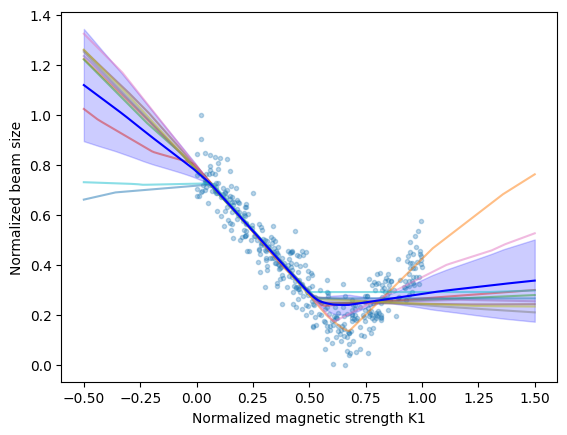

In [60]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []
for model in ensemble_models:
    # Your code here: capture the prediction of each neural network
    y_samples.append(model(x).detach().numpy().flatten())

plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=True)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')




> **Your answer here:** (Since each neural network has been trained on the same dataset, why do they give different predictions? Does the resulting uncertainty capture the aleatoric part?)

Since the initial weigths are different, the initial loss landscape are different and thus also the path the optimization takes in this landscape and the final point it reaches will be different, leading to different models.

# Monte-Carlo Dropout

We now use a Monte-Carlo drop-out neural network to try to assess the uncertainty.

In [ ]:
class MCDropoutModel(nn.Module):

    def __init__(self, p):
        """
        Initialize a Monte-Carlo drop-out neural network

        p: float
            Drop-out probability
        """
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 1),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [ ]:
def generate_and_train_dropout_model( p=0.1, epochs=100, plot_loss=True ):
    """
    Train an MC drop-out neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object
    """
    model = MCDropoutModel(p)

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        output = model(normed_train_x)
        loss = nn.MSELoss()(normed_train_y, output)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )

    return model

In [ ]:
# Train the neural network in the presence of Drop-out
mcdropout_model = generate_and_train_dropout_model(epochs=200)

In [ ]:
# Execute this cell several times.
# The result changes everytime, because different activation neurons are set to 0 (with probability p).
# This gives the uncertainty on the prediction.
mcdropout_model( torch.tensor([[0.3]]) )

> ### **Task:**
> Generate 10 different sample predictions with the MC dropout model, and plot the samples with their corresponding uncertainty.

In [ ]:
# Your code here

> ### **Task:**
> Execute the cell below, and plot samples with uncertainty bands for the model. What happens and why?

In [ ]:
mcdropout_model.eval(); # Set in evaluation mode (this can be reverted by doing `mcdropout_model.train()`)

> **Your answer here:** (What happens and why?)

# Quantile regression

We will now evaluate the uncertainty using quantile regression.

In quantile regression, we instantiate a regular neural network, but train it with specific loss function (see the slides) instead of the usual Mean Squared Error loss function.

> ### **Task:**
> Implement the quantile regression loss function in the cell below, and execute the following cells to fit quantile regression models to the data. Hint: use `torch.where`

In [86]:
def quantile_loss_function(y_true, y_pred, tau):
    """
    Return the loss function for quantile regression

    y_true: array of shape (n,1)
        data labels

    y_pred: array of shape (n,1)
        predictions of the machine learning model

    tau: float
        (number between 0 and 1)
    """

    error = y_true - y_pred
    loss = torch.mean(torch.where(error>0, tau*error, (1-tau)*(-error)), axis=0)

    return loss

In [87]:
def generate_and_train_quantile_model( tau, epochs=100, plot_loss=True ):
    """
    Train an quantile neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object

    quantile: float
        (number between 0 and 1)
    """
    model = NNModel()

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        output = model(normed_train_x)
        loss = quantile_loss_function(normed_train_y, output, tau=tau)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )

    return model

100%|██████████| 200/200 [00:00<00:00, 666.96it/s]


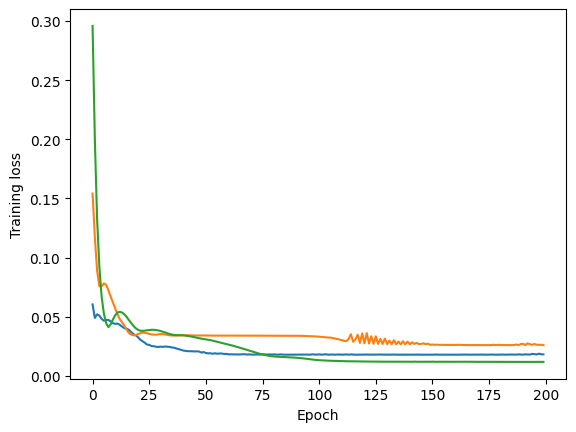

In [88]:
# Pick a few quantile values, and train a neural networks for each of them
tau_values = [0.2, 0.5, 0.9]
quantile_models = [ generate_and_train_quantile_model(tau, epochs=200) for tau in tau_values ]

Text(0, 0.5, 'Normalized beam size')

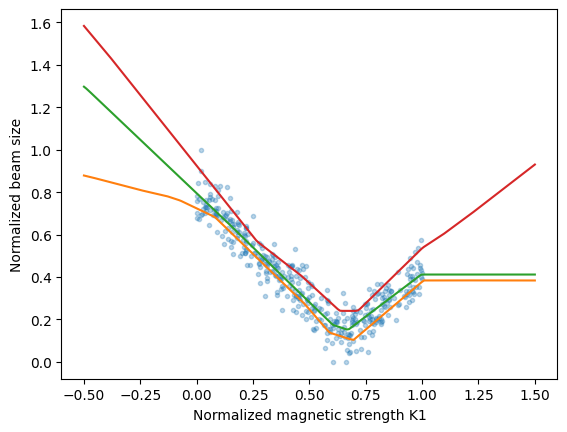

In [89]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

for model in quantile_models:
    # Your code here: capture the prediction of each neural network
    y = model(x).detach().numpy().flatten()
    plt.plot(x, y)
plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')


> ### **Task:**
> Are the relative positions of the 0.2, 0.5 and 0.9 curves as expected? Does this capture the aleatoric part of the uncertainty?

Yes, they are. This captures the aleatoric part.

# Bayesian neural networks

We will now use the `blitz` package to train bayesian neural networks. `blitz` combines with standard `pytorch` neural network models.

In [ ]:
# Bayesian neural network
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

In [ ]:
# Define a bayesian neural network with two hidden layers (with 10 neurons each)

# - We use `BayesianLinear` instead of `Linear`.
#     `BayesianLinear` holds `mu` and `rho` (for each neuron) as trainable parameter, instead of the weights directly.
#     Its output is random, as it draws random weights for each evaluation
# - `variational_estimator` enables additional methods for the class, including the ELBO loss function

@variational_estimator
class BayesianModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(1, 10, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
            nn.ReLU(),
            BayesianLinear(10, 10, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
            nn.ReLU(),
            BayesianLinear(10, 1, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [ ]:
def generate_and_train_bayesian_model( epochs=1000, plot_loss=True ):
    """
    Train a Bayesian neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object
    """
    model = BayesianModel()

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):

        loss = model.sample_elbo(inputs=normed_train_x,
                                 labels=normed_train_y,
                                 criterion=nn.MSELoss(),
                                 sample_nbr=2,
                                 complexity_cost_weight=1./normed_train_x.shape[0])
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )

    return model

In [ ]:
# Train the neural network
bayesian_model = generate_and_train_bayesian_model()

> ### **Task:**
> By modifying the code below, plot the uncertainty for the Bayesian neural network.

In [ ]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []
# Your code here: Collect 10 different sample predictions



plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=True)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')